In [1]:
import os
import os.path as osp
from tqdm import tqdm
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from generator_model import Generator
import config
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class PhotoMonetDataset(Dataset):
    def __init__(self, root_photo, root_monet, transform=None):
        self.root_photo = root_photo
        self.root_monet = root_monet
        self.transform = transform
        self.monet_images = os.listdir(self.root_monet)
        self.photo_images = os.listdir(self.root_photo)
        self.num_monet = len(self.monet_images)
        self.num_photo = len(self.photo_images)
        self.len_dataset = max(self.num_monet, self.num_photo)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        monet_img = self.monet_images[index%self.num_monet]
        photo_img = self.photo_images[index%self.num_photo]

        monet_img = osp.join(self.root_monet, monet_img)
        photo_img = osp.join(self.root_photo, photo_img)

        monet_img = np.array(Image.open(monet_img).convert("RGB"))
        photo_img = np.array(Image.open(photo_img).convert("RGB"))

        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)

        return monet_img, photo_img


In [3]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((256, 256)),                
                transforms.Normalize([0.5 for _ in range(3)],[0.5 for _ in range(3)]),
        ])

test_dataset = PhotoMonetDataset(osp.join("../monet2photo", "testB"), 
                            osp.join("../monet2photo", "testA"),
                            transform=transform)

print(test_dataset.__len__())
test_dataloader = DataLoader(test_dataset, 1, shuffle=False, num_workers=4)


751


In [15]:
gen_w_i = Generator(in_channels=3)  # Model trained with identity loss
gen_wo_i = Generator(in_channels=3)  # Model trained without identity loss
gen_w_i.load_state_dict(torch.load("checkpoints/1212212148/gen_m_23.pth"))
# gen_wo_i.load_state_dict(torch.load("checkpoints/1212210058/gen_m_28.pth"))

<All keys matched successfully>

In [16]:
gen_w_i = gen_w_i.to("cuda")
gen_wo_i = gen_wo_i.to("cuda")

In [17]:
for i, (_, photo_img) in enumerate(tqdm(test_dataloader)):
    photo_img = photo_img.to("cuda")
    with torch.no_grad():
        fake_monet = gen_w_i(photo_img)
        # fake_monet_1 = gen_wo_i(photo_img)
    # fake_monet = (fake_monet-fake_monet.min())/(fake_monet.max()-fake_monet.min())
    grid = torch.cat((photo_img, fake_monet))
    fake_monet = make_grid(grid, normalize=True)
    # plt.imshow(fake_monet.cpu().permute(1,2,0))
    # plt.show()
    save_image(fake_monet, f"testOutputs/image_{i}.png")

100%|██████████| 751/751 [00:59<00:00, 12.64it/s]


## Code to generate progress plots

In [17]:
photo = test_dataset.__getitem__(323)[1]
photo = photo.reshape([1,3,256,256])
photo = photo.to("cuda")
outputs = [photo]

In [18]:
for i in range(0,28,5):
    ckpt_file = f"checkpoints/1212210058/gen_m_{i}.pth"
    gen_w_i.load_state_dict(torch.load(ckpt_file))
    fake_monet = gen_w_i(photo)
    outputs.append(fake_monet)

In [19]:
for i in range(0,31,5):
    ckpt_file = f"checkpoints/1212210846/gen_m_{i}.pth"
    gen_w_i.load_state_dict(torch.load(ckpt_file))
    fake_monet = gen_w_i(photo)
    outputs.append(fake_monet)

In [20]:
for i in range(0,11,5):
    ckpt_file = f"checkpoints/1212212148/gen_m_{i}.pth"
    gen_w_i.load_state_dict(torch.load(ckpt_file))
    fake_monet = gen_w_i(photo)
    outputs.append(fake_monet)

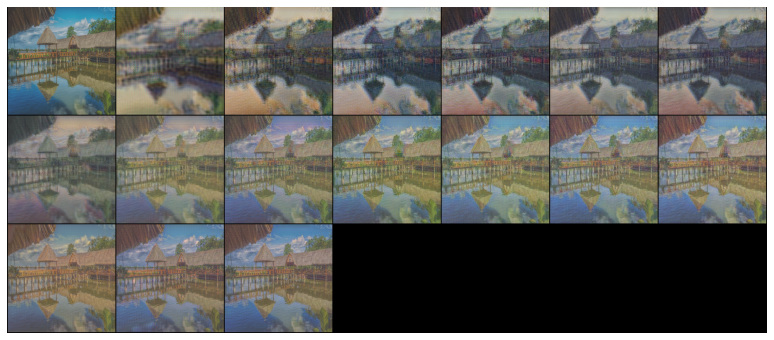

In [21]:
grid = make_grid(torch.cat(outputs), normalize=True, nrow=7)
# save_image(grid, "progress.png")
fig = plt.figure()
fig.set_size_inches(21, 6)
plt.imshow(grid.cpu().permute(1,2,0))
plt.axis("off")
fig.savefig("plots/progress.png", dpi=200)

## Significance of Identity Loss

100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


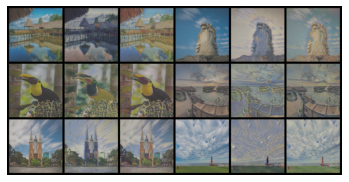

In [14]:
outputs = []
photos = [323, 13, 433, 463, 446, 319]
ckpt_file = ["checkpoints/1212210058/gen_m_28.pth", "checkpoints/1212210846/gen_m_31.pth"]
for photo_id in tqdm(photos):
    photo = test_dataset.__getitem__(photo_id)[1]
    photo = photo.reshape([1,3,256,256])
    photo = photo.to("cuda")
    outputs.append(photo)
    for file in ckpt_file:
        gen_w_i.load_state_dict(torch.load(file))
        outputs.append(gen_w_i(photo))

grid = make_grid(torch.cat(outputs), normalize=True, nrow=6, padding=10)
# save_image(grid, "progress.png")
fig = plt.figure()
# fig.set_size_inches(5*len(photos), 5*3)
plt.imshow(grid.cpu().permute(1,2,0))
plt.axis("off")
fig.savefig("plots/identity_loss_comp.png", dpi=200)

## Cycle Consistency

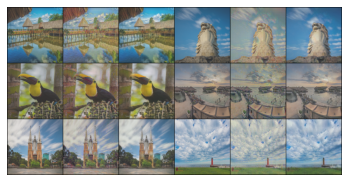

In [22]:
torch.cuda.empty_cache()
gen_p = Generator(in_channels=3)
gen_p.load_state_dict(torch.load("checkpoints/1212210846/gen_p_31.pth"))
gen_p.to("cuda")

gen_w_i = Generator(in_channels=3)
gen_w_i.load_state_dict(torch.load("checkpoints/1212210846/gen_m_31.pth"))
gen_w_i.to("cuda")

photos = [323, 13, 433, 463, 446, 319]
outputs = []

for photo_id in photos:
    photo = test_dataset.__getitem__(photo_id)[1]
    photo = photo.reshape([1,3,256,256])
    photo = photo.to("cuda")
    outputs.append(photo)
    
    fake_monet = gen_w_i(photo)
    cycle_photo = gen_p(fake_monet)
    outputs.append(fake_monet)
    outputs.append(cycle_photo)

grid = make_grid(torch.cat(outputs), normalize=True, nrow=6)
save_image(grid, "plots/cycle_consistency.png")
# fig = plt.figure()
# fig.set_size_inches(18,6)
plt.imshow(grid.cpu().permute(1,2,0))
plt.axis("off")
# plt.savefig("plots/cycle_consistency.png", dpi=100)
plt.show()